In [1]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\Users\Andrei\anaconda3\envs\torchenv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andrei\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [2]:
classifier("This is such a shit movie")

[{'label': 'NEGATIVE', 'score': 0.999560534954071}]

In [3]:
classifier("This shit is fantastic")

[{'label': 'POSITIVE', 'score': 0.9998089671134949}]

In [6]:
classifier(["Great movie!", "Awful movie!"])

[{'label': 'POSITIVE', 'score': 0.9998645782470703},
 {'label': 'NEGATIVE', 'score': 0.9997898936271667}]

In [7]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-07-18 01:44:44--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: 'AirlineTweets.csv'

     0K .......... .......... .......... .......... ..........  1% 3.07M 1s
    50K .......... .......... .......... .......... ..........  2%  272K 6s
   100K .......... .......... .......... .......... ..........  4%  314K 8s
   150K .......... .......... .......... .......... ..........  5% 4.61M 6s
   200K .......... .......... .......... .......... ..........  7% 5.51M 5s
   250K .......... .......... .......... .......... ..........  8%  264K 6s
   300K .......... .......... .......... .......... .......... 10% 24.3M 5s
   350K .......... .......... .......... .......... .......... 11%  286K 5s
   400K .......... .......... 

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [9]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [10]:
import torch

torch.cuda.current_device()

0

In [11]:
df = pd.read_csv('AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [12]:
df = df[["airline_sentiment", "text"]].copy()

In [13]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [14]:
df = df[df.airline_sentiment != "neutral"].copy()

In [15]:
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [20]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [21]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


<Axes: >

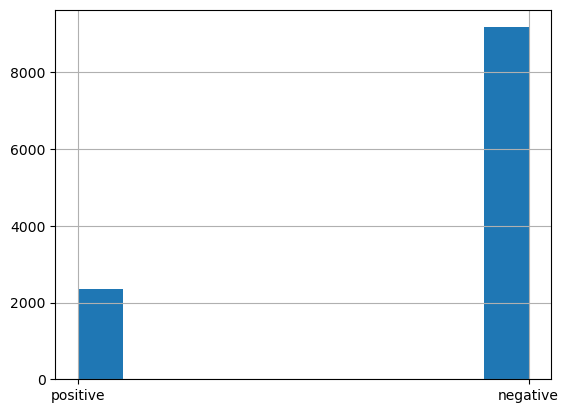

In [22]:
df['airline_sentiment'].hist()

In [23]:
len(df)

11541

In [24]:
texts = df['text'].tolist()
texts

["@VirginAmerica plus you've added commercials to the experience... tacky.",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p",
 "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlX

In [25]:
predictions = classifier(texts)

In [27]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] for d in predictions]

In [28]:
probs

[0.607088029384613,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574825763702393,
 0.9553211331367493,
 0.9827086925506592,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.01542818546295166,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934479594230652,
 0.9976067543029785,
 0.8661732077598572,
 0.0003237724304199219,
 0.8415601849555969,
 0.0032317638397216797,
 0.9997846484184265,
 0.17614632844924927,
 0.9993895292282104,
 0.09156548976898193,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.9911696910858154,
 0.01255035400390625,
 0.00809931755065918,
 0.9

In [29]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [30]:
preds = np.array(preds)

In [31]:
print("acc: ", np.mean(df['target'] == preds))

acc:  0.8898708950697514


In [32]:
cm = confusion_matrix(y_true=df['target'], y_pred=preds, normalize='true')

In [33]:
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

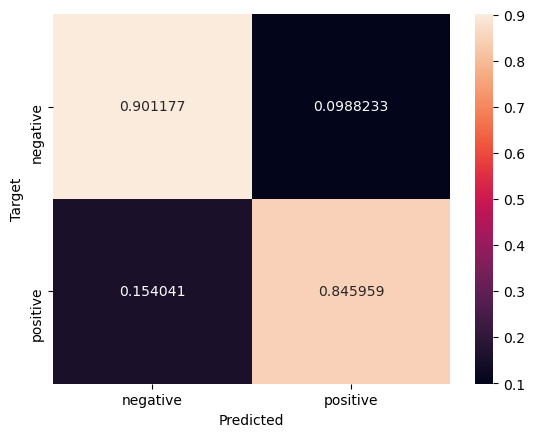

In [34]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [35]:
f1_score(y_true=df['target'], y_pred=preds)

0.7587777566900741

In [36]:
f1_score(1 - df['target'], 1 - preds)

0.928647616908999

In [37]:
roc_auc_score(df['target'], preds)

0.8735676271257872

In [38]:
roc_auc_score(1 - df['target'], 1 - preds)

0.8735676271257871